# LAB10

Use reinforcement learning to devise a tic-tac-toe player.

### Deadlines:

* Submission: [Dies Natalis Solis Invicti](https://en.wikipedia.org/wiki/Sol_Invictus)
* Reviews: [Befana](https://en.wikipedia.org/wiki/Befana)

Notes:

* Reviews will be assigned  on Monday, December 4
* You need to commit in order to be selected as a reviewer (ie. better to commit an empty work than not to commit)

In [1381]:
from dataclasses import dataclass
from random import randint
from tqdm import tqdm
import pickle
import ipywidgets as widgets
from IPython.display import display
import threading
import math
import matplotlib.pyplot as plt

In [1382]:
GAME_SIZE = 2000000
LR = 0.3
DECAY = 5
EPSILON = 0.05
BATCH = 5000

In [1383]:
@dataclass
class Player:
    marker: str
    startegy: callable
    table_points: [[]]
    practice: bool

    

In [1384]:
import random

class TicTacToe:
    def __init__(self) -> None:
        self._table = [[6,1,8],[7,5,3],[2,9,4]] 
        self._game = [[" ", " ", " "],[" ", " ", " "],[" ", " ", " "]]
        self._row = 3
        self._column = 3
        self._available_moves = 9

    def printGame(self):
        for i in range(len(self._game)):
            for j in range(len(self._game[i])):
                print("| "+str(self._game[i][j]) ,end =" ")
            print("|\n  -   -   -")
        print("\n")
    
    def move(self, coordinates , player: Player):
        if self._row <= coordinates[0] or self._column <= coordinates[1]:
            return -1
        if self._game[coordinates[0]][coordinates[1]] != " ":
            return -1
        self._game[coordinates[0]][coordinates[1]] = player.marker
        return 1
    
    def check_game(self):
        #ROW
        for i in range(len(self._game)):
            count_x = 0
            count_o = 0
            for j in range(len(self._game[i])):
                if self._game[i][j] == "X":
                    count_x += 1
                if self._game[i][j] == "O":
                    count_o += 1
            if count_x == 3:
                return "X"
            elif count_o == 3:
                return "O"
        #COLUMN
        for i in range(len(self._game)):
            count_x = 0
            count_o = 0
            for j in range(len(self._game[i])):    
                if self._game[j][i] == "X":
                    count_x += 1
                if self._game[j][i] == "O":
                    count_o += 1
            if count_x == 3:
                return "X"
            elif count_o == 3:
                return "O"
        #DIAG
        for i in range(len(self._game)):
            count_x = 0
            count_o = 0
            if self._game[i][i] == "X":
                count_x += 1
            if self._game[i][i] == "O":
                count_o += 1
            if count_x == 3:
                return "X"
            elif count_o == 3:
                return "O"

        #DIAG inv
        for i in range(len(self._game)):
            count_x = 0
            count_o = 0
            if self._game[i][self._column-i-1] == "X":
                count_x += 1
            if self._game[i][self._column-i-1] == "O":
                count_o += 1
            if count_x == 3:
                return "X"
            elif count_o == 3:
                return "O"

        return "-1"

In [1385]:
def random_strategy(player: Player, TicTacToe: TicTacToe, epsilon= EPSILON):
        row = randint(0,TicTacToe._row-1)
        column = randint(0,TicTacToe._row-1)
        return (row, column)


In [1386]:
def current_value(player: Player, ticTacToe: TicTacToe):
    val = 0
    for i in range(len(player.table_points)):
        for j in range(len(player.table_points[i])):
            if player.table_points[i][j][1] == 1 and ticTacToe._game[i][j] == player.marker:
                val += player.table_points[i][j][0]
    return val

In [1387]:
def reinforcement_strategy(player:Player ,ticTacToe: TicTacToe, epsilon= EPSILON):
    max_x = 0
    max_y = 0
    max_val = -9999
    new_val = 0

    if random.random() < epsilon and player.practice == True:
        row = randint(0,ticTacToe._row-1)
        column = randint(0,ticTacToe._row-1)
        while player.table_points[row][column][1] != 0 and ticTacToe._game[row][column] != " ":
            row = randint(0,ticTacToe._row-1)
            column = randint(0,ticTacToe._row-1)
        player.table_points[row][column] = (player.table_points[row][column][0], 1)
        return (row, column)
    else:
        current_val = current_value(player, ticTacToe)
        for i in range(len(player.table_points)):
            for j in range(len(player.table_points[i])):
                if player.table_points[i][j][1] == 0 and ticTacToe._game[i][j] == " ":
                    new_val = current_val+player.table_points[i][j][0]
                    if new_val> max_val:
                        max_x = i
                        max_y = j
                        max_val = new_val
        player.table_points[max_x][max_y] = (player.table_points[max_x][max_y][0], 1)
    return (max_x, max_y)

In [1388]:
tictactoe = TicTacToe()
player_X = Player( "X", reinforcement_strategy, [[(random.random(), 0) for _ in range(tictactoe._column)] for _ in range(tictactoe._row)], True)
player_O = Player( "O", random_strategy, [[(random.random(), 0)for _ in range(tictactoe._column)] for _ in range(tictactoe._row)], True)


In [1389]:
def play(ticTacToe: TicTacToe, epsilon= EPSILON):
    turn = 0
    while ticTacToe._available_moves != 0 :
        if turn == 0:
            player = player_X
        else:
            player = player_O
        
        while ticTacToe.move(player.startegy(player,ticTacToe,epsilon), player)!= 1:
            continue
        winner = ticTacToe.check_game()
        if winner != "-1":
            return winner
        turn = 1- turn    
        ticTacToe._available_moves -=1
    return -1

In [1390]:
def stick_and_carrot(winner, training):
    MUL = 0
    reward = 0
    if winner == -1:
        MUL = 0
    elif winner=="X":
        MUL = 1
    elif winner == "O":
        MUL = -0.8
     
    for i in range(len(player_X.table_points)):
        for j in range(len(player_X.table_points[i])):
            if  player_X.table_points[i][j][1] == 1:
                
                reward = ((MUL - player_X.table_points[i][j][0])*LR)
                new_val = player_X.table_points[i][j][0] + reward*training
                
                player_X.table_points[i][j] = (new_val, 0)   
    return reward
   

In [1391]:
def savePolicy():
        fw = open('policy_final', 'wb')
        pickle.dump(player_X.table_points, fw)
        fw.close()

def loadPolicy(file):
        fr = open(file, 'rb')
        player_X.table_points = pickle.load(fr)
        fr.close()

In [1392]:
def practice():
    epsilon_hist=[]
    avg_win_hist =[]
    epsilon = 1
    win_cunter = 0
    batch = 1
    for i in tqdm(range(GAME_SIZE)):
        ticTac = TicTacToe()
        epsilon = 1* math.exp(-((i*DECAY)/(GAME_SIZE-1)))
        epsilon_hist.append(epsilon)
        winner = play(ticTac, epsilon)
        batch+=1
        if winner == "X":
            win_cunter+=1
        if batch == BATCH:
            batch = 1
            avg_win_hist.append((win_cunter/(BATCH))*100)
            win_cunter =0
        
        stick_and_carrot(winner, 1)
    savePolicy()
    return epsilon_hist, avg_win_hist


In [1393]:
def real_game(load):
    counter = 0
    if load:
        loadPolicy("policy_final")
    player_X.practice = False
    player_O.practice = False
    print(player_X.table_points)
    for i in tqdm(range(GAME_SIZE)):
        ticTac = TicTacToe()
        stick_and_carrot(0,0)
        winner = play(ticTac)
        if winner == "X":
            counter+=1
    print(f"WIN RATE: {(counter/GAME_SIZE) *100}%")
    ticTac.printGame()
    print(player_X.table_points)

In [1394]:
class InputHandler:
    def __init__(self):
        self.input_value = None
        self.input_event = threading.Event()

    def get_input(self, prompt):
        print(prompt, end='', flush=True)
        self.input_value = None
        self.input_event.clear()
        
        input_thread = threading.Thread(target=self._input_thread)
        input_thread.start()

        self.input_event.wait()

        return self.input_value

    def _input_thread(self):
        try:
            self.input_value = input()
        except EOFError:
            pass  

        self.input_event.set()

In [1395]:
input_handler = InputHandler()

In [1396]:
def game_vs_human(ticTacToe: TicTacToe, load):
    player_X.practice = False
    player_O.practice = False
    if load:
        loadPolicy("policy_final")
    turn = 0
    while ticTacToe._available_moves != 0 :
        if turn == 1:
            player = player_O
            row = int(input_handler.get_input("Inserisci riga: "))
            column = int(input_handler.get_input("Inserisci colonna: "))
            print(row,column)
            while ticTacToe.move((row, column), player)!= 1:
                row = int(input_handler.get_input("Inserisci riga: "))
                column = int(input_handler.get_input("Inserisci colonna: "))
                print(row,column)
        else:
            print("ROBOT")
            player = player_X
            while ticTacToe.move(player.startegy(player,ticTacToe), player)!= 1:
                continue
        winner = ticTacToe.check_game()
        ticTacToe.printGame()
        if winner != "-1":
            print(f"Player: {winner} won")
            return winner
        turn = 1- turn    
        ticTacToe._available_moves -=1
    ticTacToe.printGame()
    return "Draw"
    

In [1397]:
def plotter(epsilon, win):
    episode = list(range(1, len(epsilon) + 1))
    plt.plot(episode,epsilon, marker='o', linestyle='-', color='b')
    plt.title('Epsilon Decay')
    plt.xlabel('Episode')
    plt.ylabel('Epsilon')
    plt.grid(True)
    plt.savefig('EPSILON_DECAY')
    plt.show() 

    episode = list(range(1, int(GAME_SIZE/BATCH) +1))
    plt.plot(episode,win, marker='o', linestyle='-', color='r')
    plt.title('Win Rate over Episode')
    plt.xlabel('Episode')
    plt.ylabel('Win Rate')
    plt.grid(True)
    plt.savefig('WINNING RATE')
    plt.show() 



In [1398]:
def gameplay(load):
    if not load:
        epsilon, win = practice()
        plotter(epsilon,win)
    real_game(load)
    tictactoe = TicTacToe()
    game_vs_human(tictactoe, load)

  1%|          | 14692/2000000 [00:01<03:26, 9620.12it/s] 

100%|██████████| 2000000/2000000 [01:45<00:00, 19009.56it/s]


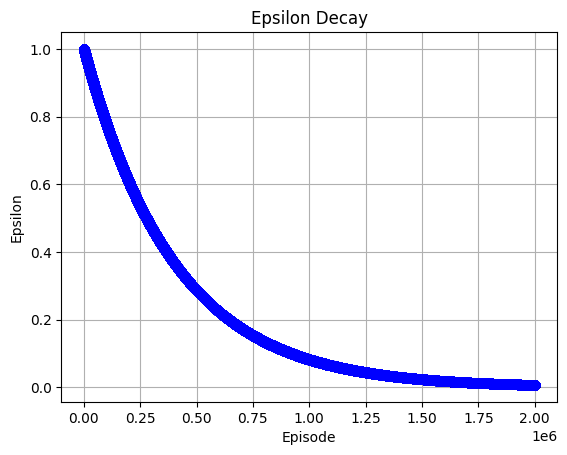

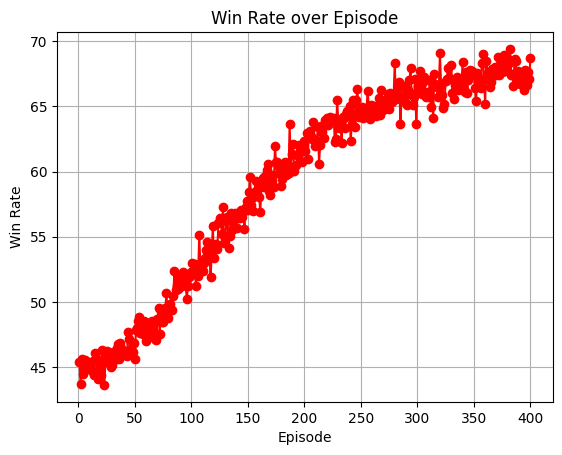

[[(-0.04680006204719117, 0), (0.6456330981427271, 0), (-0.2588712729238799, 0)], [(-0.040776229146116685, 0), (0.6911189171794353, 0), (0.06184400525019337, 0)], [(-0.13377970231221345, 0), (0.6416778789558163, 0), (-0.07793511125178662, 0)]]


100%|██████████| 2000000/2000000 [01:27<00:00, 22752.44it/s]


WIN RATE: 78.11160000000001%
|   | O | O |
  -   -   -
| X | X | X |
  -   -   -
|   | X | O |
  -   -   -


[[(-0.04680006204719117, 0), (0.6456330981427271, 0), (-0.2588712729238799, 0)], [(-0.040776229146116685, 1), (0.6911189171794353, 1), (0.06184400525019337, 1)], [(-0.13377970231221345, 0), (0.6416778789558163, 1), (-0.07793511125178662, 0)]]


In [1399]:
gameplay(False)